<a href="https://colab.research.google.com/github/mudmemeshiba/GenderClassification/blob/main/Customized_Gender_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Setting Up Drive

In [ ]:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -la /content/drive/MyDrive/y3/deep

total 275895
drwx------ 2 root root      4096 Nov  3 13:12 dataset
-rw------- 1 root root 282512091 Nov  2 19:41 Dataset.zip


In [ ]:
# !unzip "/content/drive/MyDrive/y3/deep/Dataset.zip" -d "/content/dataset" #Unzip file from drive
!unzip "/content/Dataset.zip" -d "/content/dataset" #Unzip file from drive

In [ ]:
!nvidia-smi -L || true  # check GPU
import torch, platform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch:", torch.__version__)
print("Device :", device, "| Python:", platform.python_version())

GPU 0: Tesla T4 (UUID: GPU-0784f1a6-aee5-f449-4353-cdaeaaee543b)
PyTorch: 2.8.0+cu126
Device : cuda | Python: 3.12.12


In [ ]:
import os, time, copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

# use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Config Base directory path as needed
# BASE_DIR  = "/content/drive/MyDrive/y3/deep/dataset"
BASE_DIR  = "/content/dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "Training")    # training images
TEST_DIR  = os.path.join(BASE_DIR, "Validation")  # validation images

# Image settings, Hyperparameter
IMG_SIZE   = 224      # Input image size (h x w)
BATCH_SIZE = 32       # Number of images per batch
SEED       = 1337     # reproducibility
torch.manual_seed(SEED)


Device: cuda


## Data Augmentation (Transform)

In [ ]:
# Image Transformation
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                 # Convert image to the same size
    transforms.RandomHorizontalFlip(0.5),                    # Randomly flip (horizontal)
    transforms.RandomRotation(5),                            # Rotate +- 5 Degress
    transforms.ColorJitter(brightness=0.1, contrast=0.1),    # Adjust Brightness and Contrast
    transforms.ToTensor(),                                   # Convert to PyTorch tensor (C, H, W)
    transforms.Normalize([0.485, 0.456, 0.406],              # Normalize using ImageNet mean
                         [0.229, 0.224, 0.225])              # Standard deviation
])

# Define image transformations for validation/test sets
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                 # Resize all images to the same size
    transforms.ToTensor(),                                   # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406],              # Normalize with same parameters
                         [0.229, 0.224, 0.225])
])

# Load the training dataset from directory
full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
class_names = full_train.classes                             # Get list of class names (e.g., ['female', 'male'])
num_classes = len(class_names)
print("Classes:", class_names)

# Split dataset into training and validation subsets
val_ratio = 0.2                                               # 20% of data used for validation
num_total = len(full_train)                                   # Total number of images
indices = np.arange(num_total)                                # Create array of indices
np.random.seed(SEED); np.random.shuffle(indices)              # Shuffle indices using fixed seed
val_size = int(num_total * val_ratio)                         # Calculate validation set size
val_idx, train_idx = indices[:val_size], indices[val_size:]   # Split indices for val/train sets

# Create subset datasets using the shuffled indices
train_subset = torch.utils.data.Subset(full_train, train_idx)  # Training subset with augmentations
val_subset   = torch.utils.data.Subset(
    datasets.ImageFolder(TRAIN_DIR, transform=test_tfms), val_idx)  # Validation subset with test transforms

# Load test dataset (separate folder)
test_set = datasets.ImageFolder(TEST_DIR, transform=test_tfms)


Classes: ['female', 'male']


## Class Imbalance

Compute balanced sampling weights for training set

In [ ]:
# get class label for each image in training set
targets = np.array([full_train.samples[i][1] for i in train_idx])
class_count = np.bincount(targets, minlength=num_classes)
# avoid div zero
class_weights = 1.0 / (class_count + 1e-6)
# assign a sample weight
sample_weights = class_weights[targets]
# Balance the image by loading unfrequent image
sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

## Data Loader

Load data for each set and set it to desired batch size

In [ ]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE,
                          sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2, pin_memory=True)


# Model

Designed a miniCNN model that contains 3 Convolutional layers

In [ ]:
import torch
import torch.nn as nn

class MiniCNN(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2),      # 224 -> 112

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2),      # 112 -> 56

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(2),      # 56 -> 28
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # -> (128,1,1)
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ใช้งาน
model = MiniCNN(num_classes=1).to(device)


## Loss, Optimizer, Scheduler

In [ ]:
criterion = nn.BCEWithLogitsLoss()   # How wrong the model is (loss function)
optimizer = optim.Adam(model.parameters(), lr=1e-4) # How to adjust weights to reduce error
scheduler = optim.lr_scheduler.ReduceLROnPlateau( # reduce learning rate
    optimizer, mode='min', factor=0.5, patience=2)

## Train/Validate

In [ ]:
# Use mixed precision training (faster on GPU)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

def epoch_run(loader, train_mode=True):
    if train_mode:
        model.train()   # Enable training mode (dropout, BN update)
    else:
        model.eval()    # Evaluation mode (no dropout, no BN update)

    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad(set_to_none=True)   # Reset gradients
        with torch.set_grad_enabled(train_mode): # Compute grads only if training
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")): # Mixed precision
                logits = model(imgs).squeeze(1)  # Forward pass
                loss = criterion(logits, labels) # Compute loss

            if train_mode:
                scaler.scale(loss).backward()    # Backprop (scaled)
                scaler.step(optimizer)           # Optimizer update
                scaler.update()                  # Update scaler for next step

        preds = (torch.sigmoid(logits) >= 0.5).long()  # Convert logits → binary preds
        running_loss += loss.item() * imgs.size(0)     # Accumulate total loss
        correct += (preds.cpu() == labels.long().cpu()).sum().item()  # Count correct preds
        total += imgs.size(0)

    return running_loss/total, correct/total  # Return avg loss and accuracy


/tmp/ipython-input-4143029229.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


## Training Loop

In [ ]:
def train_model(epochs=10, patience=3):
    best_w = copy.deepcopy(model.state_dict())   # Keep best model weights
    best_acc = 0                                 # Track best validation accuracy
    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}  # Store metrics
    no_improve = 0                               # Counter for early stopping

    for ep in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = epoch_run(train_loader, True)   # Run one training epoch
        val_loss, val_acc = epoch_run(val_loader, False)  # Evaluate on validation set
        scheduler.step(val_loss)                          # Adjust LR if val_loss not improving

        # Save metrics
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print progress
        print(f"Epoch {ep:02d}: "
              f"Train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"Val loss {val_loss:.4f} acc {val_acc:.4f} | "
              f"Time {time.time()-t0:.1f}s")

        # Save model if validation accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_w = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "/content/best_minicnn.pth")
            print("  ↳ Saved new best model")
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:           # Stop if no improvement for N epochs
                print("Early stopping!")
                break

    model.load_state_dict(best_w)                # Load best model weights
    return history

# Train model with early stopping
history = train_model(epochs=10, patience=3)


/tmp/ipython-input-4143029229.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 01: Train loss 0.6338 acc 0.6453 | Val loss 0.6135 acc 0.6781 | Time 173.8s
  ↳ Saved new best model
Epoch 02: Train loss 0.5831 acc 0.7015 | Val loss 0.5441 acc 0.7325 | Time 159.9s
  ↳ Saved new best model
Epoch 03: Train loss 0.5397 acc 0.7363 | Val loss 0.5712 acc 0.7048 | Time 154.9s
Epoch 04: Train loss 0.5003 acc 0.7687 | Val loss 0.4515 acc 0.8109 | Time 160.5s
  ↳ Saved new best model
Epoch 05: Train loss 0.4685 acc 0.7841 | Val loss 0.4591 acc 0.7887 | Time 155.8s
Epoch 06: Train loss 0.4484 acc 0.8000 | Val loss 0.4063 acc 0.8309 | Time 159.5s
  ↳ Saved new best model
Epoch 07: Train loss 0.4232 acc 0.8120 | Val loss 0.3801 acc 0.8451 | Time 155.6s
  ↳ Saved new best model
Epoch 08: Train loss 0.4134 acc 0.8175 | Val loss 0.3648 acc 0.8596 | Time 157.4s
  ↳ Saved new best model
Epoch 09: Train loss 0.4012 acc 0.8233 | Val loss 0.3426 acc 0.8649 | Time 155.8s
  ↳ Saved new best model
Epoch 10: Train loss 0.3964 acc 0.8260 | Val loss 0.3471 acc 0.8596 | Time 154.8s


## Test set Evaluation

In [ ]:
model.eval()                                 # Evaluation mode
all_logits, all_labels = [], []

# Disable gradient calculation
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)               # Move images to GPU/CPU
        logits = model(imgs).squeeze(1)      # Forward pass → raw output (logits)
        all_logits.append(logits.cpu())      # Collect logits on CPU
        all_labels.append(labels.float())    # Collect true labels

# all batches → single tensors
logits = torch.cat(all_logits)
labels = torch.cat(all_labels)

# logits → probabilities → binary predictions
probs = torch.sigmoid(logits).numpy()
preds = (probs >= 0.5).astype(int)

print(classification_report(labels.numpy().astype(int), preds, target_names=class_names))
cm = confusion_matrix(labels.numpy().astype(int), preds)
print("Confusion matrix:\n", cm)


              precision    recall  f1-score   support

      female       0.89      0.83      0.86      5841
        male       0.84      0.90      0.87      5808

    accuracy                           0.86     11649
   macro avg       0.87      0.87      0.86     11649
weighted avg       0.87      0.86      0.86     11649

Confusion matrix:
 [[4848  993]
 [ 580 5228]]


## Confusion Matrix (show the matrix)

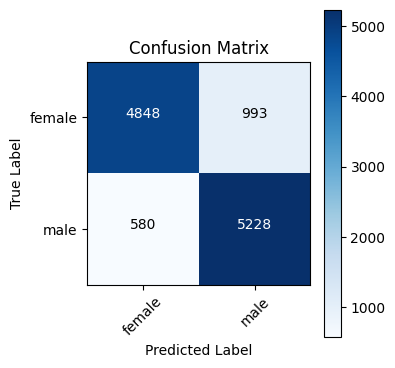

In [ ]:
def plot_cm(cm, classes):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

plot_cm(cm, class_names)


## Inference

Get the prediction with real images (not from the dataset)

In [ ]:
from PIL import Image

def predict_image(path):
    img = Image.open(path).convert("RGB")      # Load image -> RGB format
    x = test_tfms(img).unsqueeze(0).to(device) # Test transforms, batch dim with GPU/CPU

    with torch.no_grad():                      # Disable gradient calc (inference mode)
        logit = model(x).squeeze(1)            # Forward pass → raw model output (logit)
        prob = torch.sigmoid(logit).item()     # Convert logit to probability (0–1)

    pred = int(prob >= 0.5)                    # Threshold at 0.5 → 0 or 1
    return class_names[pred], prob             # Return predicted class name and probability

# Example prediction
print(predict_image("/content/interence/45210.jpg"))


('female', 0.04073137044906616)


# Continue Running

## from Epoch 09 (train #1)

Train loss 0.4012 acc 0.8233 | Val loss 0.3426 acc 0.8649 | Time 155.8s
  ↳ Saved new best model

In [ ]:
import copy
import time
import torch
import torch.optim as optim

# 1) Training function
def train_model(
    epochs=10,
    patience=3,
    start_epoch=1,
    best_acc=0.0,
    ckpt_path="best.pth",
):
    global model, optimizer, scheduler

    best_w = copy.deepcopy(model.state_dict())
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    no_improve = 0

    for ep in range(start_epoch, start_epoch + epochs):
        t0 = time.time()

        # one epoch train + val
        tr_loss, tr_acc = epoch_run(train_loader, True)
        val_loss, val_acc = epoch_run(val_loader, False)
        scheduler.step(val_loss)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {ep:02d}: "
            f"Train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
            f"Val loss {val_loss:.4f} acc {val_acc:.4f} | "
            f"Time {time.time()-t0:.1f}s"
        )

        # Save new model if validation improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_w = copy.deepcopy(model.state_dict())
            no_improve = 0

            torch.save(
                {
                    "epoch": ep,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "best_acc": best_acc,
                },
                ckpt_path,
            )

            print(f"New best model saved to {ckpt_path} (val_acc={best_acc:.4f})")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {ep} (no improvement for {patience} epochs)")
                break

    # load best weights back into model
    model.load_state_dict(best_w)
    return history, best_acc


# 2) Rerun setup

model = MiniCNN(num_classes=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

# Loading previous best checkpoint (e.g. "best_0.82.pth")
ckpt_file = "best_0.82.pth"

try:
    checkpoint = torch.load(ckpt_file, map_location=device)

    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        # case 1: full checkpoint dict
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        best_acc = checkpoint["best_acc"]
        print(f"Loaded full checkpoint from epoch {start_epoch-1} (best_acc={best_acc:.2f})")
    else:
        # case 2: file only has model weights (state_dict)
        model.load_state_dict(checkpoint)
        start_epoch = 1
        best_acc = 0.82  # <-- put your known previous best here
        print("Loaded model weights only (no optimizer/scheduler).")
        print(f"Assuming previous best_acc = {best_acc:.2f}")

except FileNotFoundError:
    print("No checkpoint found, training from scratch.")
    start_epoch = 1
    best_acc = 0.0

# 3) Continue training
history, best_acc = train_model(
    epochs=20,        # run 20 more epochs
    patience=3,
    start_epoch=start_epoch,
    best_acc=best_acc,
    ckpt_path="best.pth",   # saved new best model
)

print(f"Final best_acc = {best_acc:.4f}")


Loaded model weights only (no optimizer/scheduler).
Assuming previous best_acc = 0.82


/tmp/ipython-input-4143029229.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 01: Train loss 0.5034 acc 0.7597 | Val loss 0.4785 acc 0.7701 | Time 156.7s
Epoch 02: Train loss 0.4230 acc 0.8109 | Val loss 0.3901 acc 0.8217 | Time 152.1s
New best model saved to best.pth (val_acc=0.8217)
Epoch 03: Train loss 0.3817 acc 0.8370 | Val loss 0.4011 acc 0.8158 | Time 153.3s
Epoch 04: Train loss 0.3565 acc 0.8490 | Val loss 0.3069 acc 0.8729 | Time 153.1s
New best model saved to best.pth (val_acc=0.8729)
Epoch 05: Train loss 0.3334 acc 0.8602 | Val loss 0.2601 acc 0.9034 | Time 154.3s
New best model saved to best.pth (val_acc=0.9034)
Epoch 06: Train loss 0.3120 acc 0.8716 | Val loss 0.2540 acc 0.9022 | Time 152.2s
Epoch 07: Train loss 0.2950 acc 0.8814 | Val loss 0.2766 acc 0.8848 | Time 154.9s
Epoch 08: Train loss 0.2811 acc 0.8879 | Val loss 0.2165 acc 0.9179 | Time 155.2s
New best model saved to best.pth (val_acc=0.9179)
Epoch 09: Train loss 0.2666 acc 0.8930 | Val loss 0.2355 acc 0.9094 | Time 157.0s
Epoch 10: Train loss 0.2526 acc 0.8994 | Val loss 0.2042 acc 0

In [ ]:
model.eval()                                 # Evaluation mode
all_logits, all_labels = [], []

# Disable gradient calculation
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)               # Move images to GPU/CPU
        logits = model(imgs).squeeze(1)      # Forward pass → raw output (logits)
        all_logits.append(logits.cpu())      # Collect logits on CPU
        all_labels.append(labels.float())    # Collect true labels

# all batches → single tensors
logits = torch.cat(all_logits)
labels = torch.cat(all_labels)

# logits → probabilities → binary predictions
probs = torch.sigmoid(logits).numpy()
preds = (probs >= 0.5).astype(int)

print(classification_report(labels.numpy().astype(int), preds, target_names=class_names))
cm = confusion_matrix(labels.numpy().astype(int), preds)
print("Confusion matrix:\n", cm)


              precision    recall  f1-score   support

      female       0.93      0.95      0.94      5841
        male       0.95      0.92      0.94      5808

    accuracy                           0.94     11649
   macro avg       0.94      0.94      0.94     11649
weighted avg       0.94      0.94      0.94     11649

Confusion matrix:
 [[5546  295]
 [ 438 5370]]


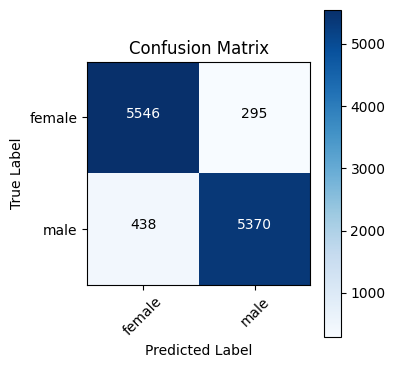

In [ ]:
def plot_cm(cm, classes):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

plot_cm(cm, class_names)


In [ ]:
from PIL import Image

def predict_image(path):
    img = Image.open(path).convert("RGB")
    x = test_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logit = model(x).squeeze(1)
        prob = torch.sigmoid(logit).item()
    pred = int(prob >= 0.5)
    return class_names[pred], prob

print(predict_image("/content/inference/45210.jpg"))


('female', 0.16267883777618408)
